In [1]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
DEVICE_ID = 3
device = torch.device(("cuda:%d" % DEVICE_ID) if torch.cuda.is_available() else "cpu")

CUDA


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
!tail rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [4]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [5]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['я ваш врач .', 'i m your doctor .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

In [8]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [9]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [10]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [11]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [12]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [13]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [14]:
def save_state(network, path='state'):
    torch.save(network.state_dict(), path)

def load_state(class_, args, path):
    network = class_(*args)
    network.load_state_dict(torch.load(path))
    return network

In [15]:
n_iters=200000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [16]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, nlayers, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        # Attention modules
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, 1)
        nn.init.xavier_normal_(self.attn.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_normal_(self.v.weight)
        
        print('Decoder created')
        

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x) # [T2,B,C]
        embedded = embedded.transpose(0, 1) # [B,T2,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        
        if teacher_forcing_ratio != 1.:
            attn_weights = []
            for _ in range(self.max_length):
                energies = self.attention(encoder_outputs, hidden[-2]) # [B,T1,T2]
                attn_weights.append(energies)
            attn_weights = torch.cat(attn_weights, dim=-1)
        else:
            # fast parallel mode
            attn_weights = self.attention(encoder_outputs, embedded) # [B,T1,T2]
            # [B,T2,T1]x[B,T1,C] -> B [T2,T1]x[T1,C] = [B, T2, C]
        
        context = torch.bmm(attn_weights.transpose(1, -1), encoder_outputs)
        output = torch.cat((embedded, context), dim=-1) # [[B,T,C];[B,T,C]] -> [B,T,C*2]
        output = self.attn_combine(output).transpose(0,1)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        logits = self.out(output)
        output = F.log_softmax(logits, dim=-1)
        return output, hidden, attn_weights
            
    def attention(self, encoder_outputs, state):
        ### [B,T1,C]x[B,C,T2] -> B [T1,C]x[C,T2] = [B,T1,T2]
        #embedded_t = state.transpose(1, -1) # [B,C,T2]
        #return F.softmax(torch.bmm(encoder_outputs, embedded_t), dim=-2)
    
        # encoder_outputs = [B,T1,C]; state = [B,T2 (if fast parallel mode) or 1,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [T1,B,C]
        state = state.transpose(0, 1)  # [T2,B,C]
        T1 = encoder_outputs.size(0)
        T2 = state.size(0)
        energies = torch.zeros(1, T1, T2).to(device)
        for i in range(T2):
            for j in range(T1):
                energies[0, j, i] = self.energy(encoder_outputs[j], state[i])
        
        energies = F.softmax(energies, dim = -2) # [1,T1,T2]
        return energies
    
    
    def energy(self, encoder_output, state):
        # encoder_output = [B,C]; embedded = [B,C]
        c = torch.cat((state, encoder_output), 1) # [B,C*2]
        energy = torch.tanh(self.attn(c)) # [B,C]
        energy = self.v(energy)
        return energy.squeeze(0)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words, dropout_p=0.1).to(device)

Decoder created


In [45]:
encoder = load_state(EncoderRNN, (input_lang.n_words, 1, hidden_size) ,'./models/encoder_state_v1_1_2')
decoder = load_state(AttnDecoder, (hidden_size, 1, output_lang.n_words, 0.1), './models/decoder_state_v1_1_2')
encoder = encoder.to(device)
decoder = decoder.to(device)

Decoder created


In [18]:
teacher_forcing_ratio = 1.
learning_rate=0.001
decoder.parameters()
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Запустим тренировку и evaluation

Train
1m 30s (- 199m 23s) (1500 0%) 3.0765
2m 58s (- 194m 54s) (3000 1%) 2.6112
4m 19s (- 187m 58s) (4500 2%) 2.3939
5m 44s (- 185m 46s) (6000 3%) 2.2446
7m 5s (- 181m 50s) (7500 3%) 2.1462
8m 25s (- 178m 52s) (9000 4%) 2.0599
9m 45s (- 176m 4s) (10500 5%) 1.9531
11m 12s (- 175m 43s) (12000 6%) 1.8534
12m 38s (- 174m 34s) (13500 6%) 1.8387
14m 11s (- 174m 59s) (15000 7%) 1.8010
15m 45s (- 175m 20s) (16500 8%) 1.7861
17m 19s (- 175m 13s) (18000 9%) 1.7106
18m 52s (- 174m 46s) (19500 9%) 1.6827
20m 23s (- 173m 49s) (21000 10%) 1.6152
21m 56s (- 173m 6s) (22500 11%) 1.5901
23m 26s (- 171m 55s) (24000 12%) 1.5181
24m 57s (- 170m 48s) (25500 12%) 1.5502
26m 27s (- 169m 30s) (27000 13%) 1.5188
27m 53s (- 167m 52s) (28500 14%) 1.4685
29m 20s (- 166m 16s) (30000 15%) 1.4288
30m 50s (- 164m 57s) (31500 15%) 1.4164
32m 8s (- 162m 41s) (33000 16%) 1.3768
33m 21s (- 160m 1s) (34500 17%) 1.3654
34m 35s (- 157m 36s) (36000 18%) 1.2839
35m 47s (- 155m 7s) (37500 18%) 1.3097
37m 5s (- 153m 7s) (39000 

<Figure size 432x288 with 0 Axes>

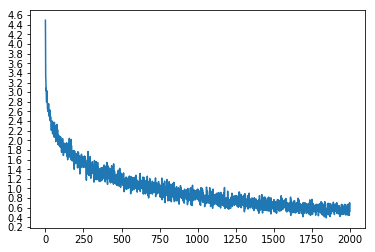

In [19]:
run_training(encoder, decoder, n_iters, print_every=1500)

In [20]:
evaluate_randomly(encoder, decoder)

> я не сумасшедший .
= i m not the crazy one .
< i m not crazy .

> мы в одном часовом поясе .
= we re in the same time zone .
< we re in the same time .

> я собираюсь это доказать .
= i m going to prove it .
< i m going to do that .

> они без ума от джаза .
= they are crazy about jazz .
< they re crazy about that .

> ты вдвое сильнее меня .
= you re twice as strong as me .
< you are twice as strong as me .

> вы прощены .
= you re forgiven .
< you re forgiven .

> вы замечательные .
= you re wonderful .
< you are wonderful .

> я не большой любитель баскетбола .
= i m not a big fan of basketball .
< i m not a big fan of basketball .

> я ранена .
= i m wounded .
< i m wounded .

> мне восемнадцать лет .
= i m eighteen .
< i m eighteen .



input = ты начинаешь меня раздражать .
output = you re beginning to worry me .


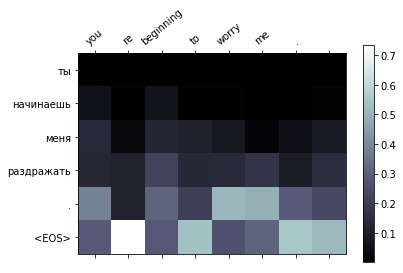

input = я собираюсь посмотреть фильм ужасов .
output = i m going to watch a scary way .


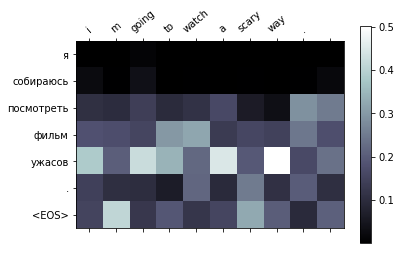

In [23]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + output_words, rotation=40)
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    attentions = attentions.transpose(0, 1)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("ты начинаешь меня раздражать .")
evaluateAndShowAttention("я собираюсь посмотреть фильм ужасов .")

In [22]:
save_state(encoder, './models/encoder_state_v1_1_2')
save_state(decoder, './models/decoder_state_v1_1_2')